In [0]:

# author: Asmaa ~ 2019
# ----------------------

# import libraries
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

# Data Preparation

### Loading Data

In [10]:
# download data
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2019-08-17 13:08:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   139MB/s    in 1.4s    

2019-08-17 13:08:20 (139 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2019-08-17 13:08:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/r

In [0]:
# extract zip files
local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [13]:
# split data
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

# print examples of file names for each category
rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock05ck01-047.png', 'rock02-081.png', 'rock02-050.png', 'rock06ck02-059.png', 'rock02-085.png', 'rock06ck02-072.png', 'rock07-k03-092.png', 'rock04-081.png', 'rock06ck02-105.png', 'rock04-016.png']
['paper07-086.png', 'paper01-017.png', 'paper05-041.png', 'paper05-077.png', 'paper05-061.png', 'paper04-016.png', 'paper01-048.png', 'paper05-013.png', 'paper06-066.png', 'paper03-096.png']
['testscissors03-059.png', 'scissors02-061.png', 'scissors04-062.png', 'testscissors02-097.png', 'scissors03-070.png', 'testscissors03-018.png', 'testscissors01-105.png', 'scissors02-005.png', 'testscissors02-033.png', 'scissors03-081.png']


### Sample Data Visualizing

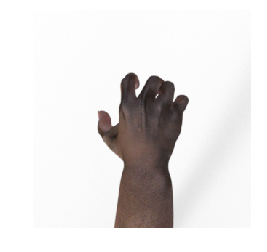

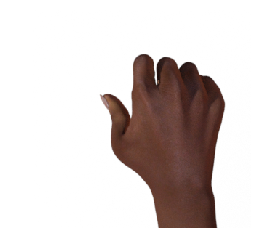

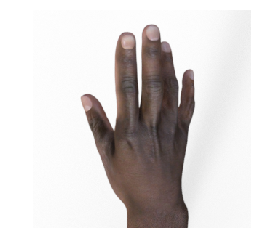

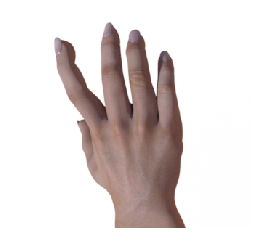

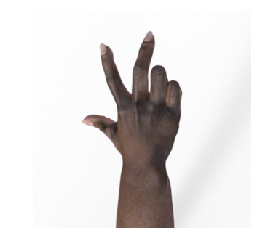

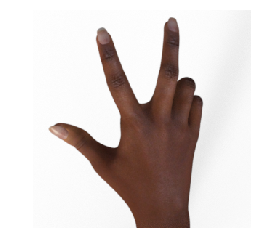

In [14]:
# rock exmaples
next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[0:2]]

# paper examples
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[0:2]]

# scissors examples
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[0:2]]

# showing examples
for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

# Pre-processing

In [15]:
# augmenting tarining set
training_datagen = ImageDataGenerator( rescale = 1./255, rotation_range=40, 
                                      width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                      zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# scaling test set
validation_datagen = ImageDataGenerator(rescale = 1./255)

# flow data generator with files
# we have to set class_mode to categorical
train_generator = training_datagen.flow_from_directory(
	'/tmp/rps/',
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	'/tmp/rps-test-set/',
	target_size=(150,150),
	class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# Building the Model

### Setting the Structure

In [16]:
# initialize the model
model = Sequential()

# add first convolution
# images are converted to 150x150, so input shape is 150x150 with 3 color channels
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))

# add second convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# add third convolution
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# add fourth convolution
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# flatten results and feed them to DNN
model.add(Flatten())

# add a hidden layer with 512 units
model.add(Dense(512, activation='relu'))

# add output layer with 3 units (number of classes)
# since it is a multi classificaiton problem we have to use softmax as an activaiton function
# which will return an array of probability which consists of 3 elements
model.add(Dense(3, activation='softmax'))

W0817 13:08:47.776973 139912514676608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Summary

In [17]:
# get summary about layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Compiling and Starting Training

In [18]:
# set functional properties of the model
# since it is a multi classificaiton problem we can use categorical_crossentropy as a loss function 
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# start training
history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)

Epoch 1/25
79/79 [==============================] - 24s 309ms/step - loss: 1.1840 - acc: 0.3861 - val_loss: 0.8350 - val_acc: 0.5054
Epoch 2/25
79/79 [==============================] - 21s 267ms/step - loss: 0.8257 - acc: 0.6532 - val_loss: 0.3015 - val_acc: 0.9839
Epoch 3/25
79/79 [==============================] - 21s 264ms/step - loss: 0.4967 - acc: 0.8016 - val_loss: 0.0684 - val_acc: 1.0000
Epoch 4/25
79/79 [==============================] - 22s 274ms/step - loss: 0.3182 - acc: 0.8790 - val_loss: 0.2546 - val_acc: 0.8898
Epoch 5/25
79/79 [==============================] - 21s 262ms/step - loss: 0.1930 - acc: 0.9325 - val_loss: 0.0509 - val_acc: 0.9839
Epoch 6/25
79/79 [==============================] - 21s 261ms/step - loss: 0.1432 - acc: 0.9512 - val_loss: 0.0967 - val_acc: 0.9570
Epoch 7/25
79/79 [==============================] - 21s 263ms/step - loss: 0.1558 - acc: 0.9460 - val_loss: 0.0340 - val_acc: 0.9866
Epoch 8/25
79/79 [==============================] - 21s 261ms/step - 

### Saving the Model

In [0]:
model.save('asmaa_rps.h5')

# Metrics Visulization

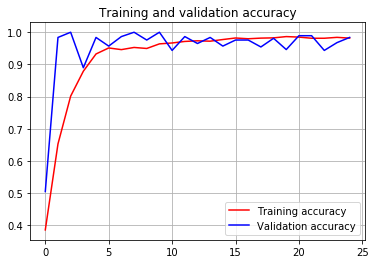

<Figure size 432x288 with 0 Axes>

In [20]:
# get metrics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# plot results
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()
plt.figure()


plt.show()

# Using the Model

In [23]:
uploaded = files.upload()

Saving paper.JPG to paper.JPG
Saving rock.JPG to rock.JPG
Saving scissors.JPG to scissors.JPG


In [24]:
print(uploaded.keys())

dict_keys(['paper.JPG', 'rock.JPG', 'scissors.JPG'])


paper.JPG
it is a paper


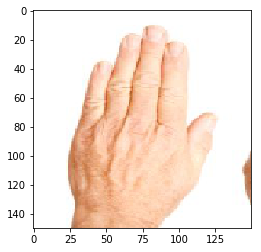

rock.JPG
it is a rock


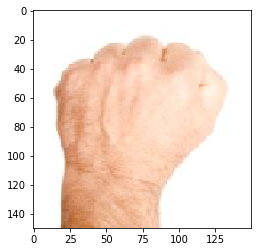

scissors.JPG
it is scissors image


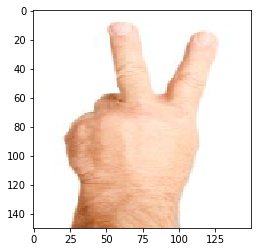

In [36]:
for fn in uploaded.keys():
 
  # open the image and convert its size to 150x150 
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  
  # convert image to numpy array
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  # predict
  classes = model.predict(images, batch_size=10)
  
  # print file name
  print(fn)
  
  # print predicted class
  # result is an array of 0s and 1s, coresponded images are sorted alphbetically
  # [paper, rock, scissors]
  
  if classes[0,0] == 1:
    plt.imshow(img)
    print('it is a paper')
    
  elif classes[0,1] == 1:
    plt.imshow(img)
    print('it is a rock')
  
  else:
    plt.imshow(img)
    print('it is scissors image')
  plt.show()